# Robyn Budget Allocator Demo

This notebook demonstrates how to use the Python implementation of Robyn's budget allocator.
It shows how to:
1. Load and prepare data
2. Configure the allocator
3. Run optimization scenarios
4. Analyze and visualize results

## Step 1: Load Exported R Data

In [1]:
## Step 1: Setup and Import
import sys
import os
import pandas as pd
import numpy as np
from typing import Dict, Any, Union, List
import matplotlib.pyplot as plt

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

# Import necessary Robyn classes
from robyn.data.entities.mmmdata import MMMData
from robyn.modeling.entities.modeloutputs import ModelOutputs
from robyn.data.entities.hyperparameters import Hyperparameters
from robyn.modeling.pareto.pareto_optimizer import ParetoResult
from utils.data_mapper import (
    load_data_from_json,
    import_input_collect,
    import_output_collect,
    import_output_models,
)

2025-03-31 00:43:26,275 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/Robyn/.pyvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data from JSON exported from R
# raw_input_collect = load_data_from_json(
#     "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/dh_Pareto_InputCollect.json"
# )
# raw_output_collect = load_data_from_json(
#     "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/dh_Allocator_OutputCollect.json"
# )

raw_input_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/test_forAllocator_2000_iterations_5_trials_InputCollect.json"
)
raw_output_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/test_forAllocator_2000_iterations_5_trials_OutputCollect.json"
)
# raw_input_collect = load_data_from_json(
#     "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/03312025_test_forAllocator_50_iterations_5_trials_InputCollect.json"
# )
# raw_output_collect = load_data_from_json(
#     "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/03312025_test_forAllocator_50_iterations_5_trials_OutputCollect.json"
# )

# raw_input_collect = load_data_from_json(
#     "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_InputCollect.json"
# )
# raw_output_collect = load_data_from_json(
#     "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_OutputCollect.json"
# )
# raw_output_models = load_data_from_json(
#     "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_OutputModels.json"
# )

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_collect = import_output_collect(raw_output_collect)
# python_model_outputs = import_output_models(raw_output_models)

# Extract individual components
mmm_data = r_input_collect["mmm_data"]
featurized_mmm_data = r_input_collect["featurized_mmm_data"]
holidays_data = r_input_collect["holidays_data"]
hyperparameters = r_input_collect["hyperparameters"]
pareto_result = r_output_collect["pareto_result"]
# Print data summary
print(f"Data loaded successfully:")
print(
    f"- Data timeframe: {mmm_data.data[mmm_data.mmmdata_spec.date_var].min()} to {mmm_data.data[mmm_data.mmmdata_spec.date_var].max()}"
)
print(
    f"- Number of paid media channels: {len(mmm_data.mmmdata_spec.paid_media_spends)}"
)
print(f"- Channels: {mmm_data.mmmdata_spec.paid_media_spends}")

Raw hyperparameters data: {'facebook_S_alphas': [0.5, 3], 'facebook_S_gammas': [0.3, 1], 'facebook_S_thetas': [0, 0.3], 'print_S_alphas': [0.5, 3], 'print_S_gammas': [0.3, 1], 'print_S_thetas': [0.1, 0.4], 'tv_S_alphas': [0.5, 3], 'tv_S_gammas': [0.3, 1], 'tv_S_thetas': [0.3, 0.8], 'search_S_alphas': [0.5, 3], 'search_S_gammas': [0.3, 1], 'search_S_thetas': [0, 0.3], 'ooh_S_alphas': [0.5, 3], 'ooh_S_gammas': [0.3, 1], 'ooh_S_thetas': [0.1, 0.4], 'newsletter_alphas': [0.5, 3], 'newsletter_gammas': [0.3, 1], 'newsletter_thetas': [0.1, 0.4], 'train_size': [0.5, 0.8]}
Data loaded successfully:
- Data timeframe: 2015-11-23 00:00:00 to 2019-11-11 00:00:00
- Number of paid media channels: 5
- Channels: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']


## Step 2: Set up Budget Allocator

Initialize the budget allocator with the selected model and data.

In [3]:
# select_model = r_output_collect["pareto_result"].pareto_solutions[
#     0
# ]  # Taking first solution as example
# print(f"Selected model: {select_model}")

In [4]:
for i in raw_output_collect["clusters"]["models"]:
    print(i["solID"])

3_216_3
3_206_5
4_182_3


In [5]:
# Override
select_model = "3_216_3"

In [6]:
r_pareto_result = r_output_collect["pareto_result"]

In [7]:
import pandas as pd

# Set display options to show all rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
# Assuming r_dt_hyppar is your DataFrame
r_dt_hyppar = r_pareto_result.result_hyp_param[
    r_pareto_result.result_hyp_param["solID"] == select_model
]
print(r_dt_hyppar)

    facebook_S_alphas  facebook_S_gammas  facebook_S_thetas  \
67           2.837947           0.431672           0.178984   

    newsletter_alphas  newsletter_gammas  newsletter_thetas  ooh_S_alphas  \
67           2.464678           0.776006           0.234129      0.586477   

    ooh_S_gammas  ooh_S_thetas  print_S_alphas  print_S_gammas  \
67      0.312751      0.360066        2.632558        0.652505   

    print_S_thetas  search_S_alphas  search_S_gammas  search_S_thetas  \
67        0.299594         2.775362         0.397679         0.274802   

    tv_S_alphas  tv_S_gammas  tv_S_thetas  train_size  rsq_train   rsq_val  \
67     2.996615     0.982781     0.307317    0.539326   0.931101  0.881608   

    rsq_test  nrmse_train  nrmse_val  nrmse_test     nrmse  decomp.rssd  mape  \
67  0.862828     0.054831   0.072477     0.10524  0.072477     0.096614     0   

         lambda  lambda_hp    lambda_max  lambda_min_ratio  pos   Elapsed  \
67  7594.525894   0.000016  6.548109e+07 

## Step 3: Run Different Optimization Scenarios

### Scenario 1: Default Max Response

In [8]:
print("Hyperparameters raw output:", hyperparameters)

Hyperparameters raw output: Hyperparameters(
  facebook_S=Hyperparameter(
  thetas=[0, 0.3],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  print_S=Hyperparameter(
  thetas=[0.1, 0.4],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  tv_S=Hyperparameter(
  thetas=[0.3, 0.8],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  search_S=Hyperparameter(
  thetas=[0, 0.3],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  ooh_S=Hyperparameter(
  thetas=[0.1, 0.4],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
  newsletter=Hyperparameter(
  thetas=[0.1, 0.4],
  shapes=None,
  scales=None,
  alphas=[0.5, 3],
  gammas=[0.3, 1],
  penalty=None
)
)


In [9]:
# Assuming `hyperparameters` is an instance of the `Hyperparameters` class

# Iterate over each channel and its hyperparameters
for channel, params in hyperparameters.hyperparameters.items():
    print(f"Channel: {channel}")
    print(f"  Thetas: {params.thetas}")
    print(f"  Shapes: {params.shapes}")
    print(f"  Scales: {params.scales}")
    print(f"  Alphas: {params.alphas}")
    print(f"  Gammas: {params.gammas}")
    print(f"  Penalty: {params.penalty}")
    print()

# Print other attributes of the Hyperparameters class
print(f"Adstock: {hyperparameters.adstock}")
print(f"Lambda: {hyperparameters.lambda_}")
print(f"Train Size: {hyperparameters.train_size}")

Channel: facebook_S
  Thetas: [0, 0.3]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: print_S
  Thetas: [0.1, 0.4]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: tv_S
  Thetas: [0.3, 0.8]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: search_S
  Thetas: [0, 0.3]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: ooh_S
  Thetas: [0.1, 0.4]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Channel: newsletter
  Thetas: [0.1, 0.4]
  Shapes: None
  Scales: None
  Alphas: [0.5, 3]
  Gammas: [0.3, 1]
  Penalty: None

Adstock: AdstockType.GEOMETRIC
Lambda: 0.0
Train Size: [0.5, 0.8]


In [10]:
print(hyperparameters.adstock.value)

geometric


In [11]:
from robyn.allocator.entities.allocation_params import AllocatorParams
from robyn.allocator.entities.allocation_result import (
    AllocationResult,
    OptimOutData,
    MainPoints,
)
from robyn.allocator.entities.optimization_result import OptimizationResult
from robyn.allocator.entities.constraints import Constraints
from robyn.allocator.optimizer import BudgetAllocator
from robyn.allocator.constants import (
    SCENARIO_MAX_RESPONSE,
    ALGO_SLSQP_AUGLAG,
    CONSTRAINT_MODE_EQ,
    DEFAULT_CONSTRAINT_MULTIPLIER,
    DATE_RANGE_ALL,
)


# Create allocator parameters matching R Example 1
allocator_params = AllocatorParams(
    scenario=SCENARIO_MAX_RESPONSE,
    total_budget=None,  # When None, uses total spend in date_range
    target_value=None,
    date_range="all",
    channel_constr_low=[0.7],  # Single value for all channels
    channel_constr_up=[1.2, 1.5, 1.5, 1.5, 1.5],  # Different values per channel
    channel_constr_multiplier=3.0,
    optim_algo="SLSQP_AUGLAG",
    maxeval=100000,
    constr_mode=CONSTRAINT_MODE_EQ,
    plots=True,
)
# 0.7 is the lower bound
# 1.2 is the upper bound for the first channel, and so on
# $70 - $150
# let's say $100, budget allocator is about increasing decreasing media budget, advertiser wants to know how much to spend on each channel
# you cannot be infinitely increasing budget, so you have to set constraints
# 0.7 - 1.2 means you can increase by 20% or decrease by 30%
# Boundedx3 = 3x increase or decrease, so 90% lower bound, 150% upper bound.

print("\nInitial constraints:")
for channel, low, up in zip(
    mmm_data.mmmdata_spec.paid_media_spends,
    [0.7] * len(mmm_data.mmmdata_spec.paid_media_spends),  # Expand single value
    [1.2, 1.5, 1.5, 1.5, 1.5],  # Per channel values
):
    print(f"{channel}: {low:.1f}x - {up:.1f}x")

# Initialize budget allocator
max_response_allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    hyperparameters=hyperparameters,
    pareto_result=pareto_result,
    select_model=select_model,
    params=allocator_params,
)

## Step 3: Run Optimization
max_response_result = max_response_allocator.optimize()

2025-03-31 00:43:32,163 - robyn.allocator.data_preparation - WARNING - The following media channels have zero coefficients and will be excluded: facebook_S



Initial constraints:
tv_S: 0.7x - 1.2x
ooh_S: 0.7x - 1.5x
print_S: 0.7x - 1.5x
facebook_S: 0.7x - 1.5x
search_S: 0.7x - 1.5x


/Users/yijuilee/robynpy_release_reviews/Robyn/.pyvenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/yijuilee/robynpy_release_reviews/Robyn/.pyvenv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


In [12]:
## Step 4: Analyze Results
print("\nOptimization Results Summary:")
print("-" * 50)
print(f"Model ID: {select_model}")
print(f"Scenario: {max_response_result.scenario}")
print(f"Use case: {max_response_result.usecase}")

results_df = pd.DataFrame(
    {
        "Channel": max_response_result.dt_optimOut.channels,
        "Initial Spend": max_response_result.dt_optimOut.init_spend_unit,
        "Optimized Spend": max_response_result.dt_optimOut.optm_spend_unit,
        "Spend Change %": (
            max_response_result.dt_optimOut.optm_spend_unit
            / max_response_result.dt_optimOut.init_spend_unit
            - 1
        )
        * 100,
        "Initial Response": max_response_result.dt_optimOut.init_response_unit,
        "Optimized Response": max_response_result.dt_optimOut.optm_response_unit,
        "Response Lift %": (
            max_response_result.dt_optimOut.optm_response_unit
            / max_response_result.dt_optimOut.init_response_unit
            - 1
        )
        * 100,
    }
)

print("\nDetailed Results:")
print(results_df.round(2))

# Print additional diagnostics
print("\nOptimization Parameters:")
print(f"Total budget: {max_response_allocator.constraints.budget_constraint:,.2f}")
print("Bound multiplier:", max_response_allocator.params.channel_constr_multiplier)
print("\nConstraint Violations:")
violations = np.sum(
    np.abs(
        max_response_result.dt_optimOut.optm_spend_unit
        - max_response_allocator.allocator_data_preparer.init_spend_unit
    )
)
print(f"Total allocation adjustment: {violations:,.2f}")


Optimization Results Summary:
--------------------------------------------------
Model ID: 3_216_3
Scenario: max_response
Use case: all_historical_vec + historical_budget

Detailed Results:
      Channel  Initial Spend  Optimized Spend  Spend Change %  \
0        tv_S       16282.26         11397.58          -30.00   
1       ooh_S       52818.55         56310.65            6.61   
2     print_S        3856.63          2699.64          -30.00   
3  facebook_S        2141.53             0.00         -100.00   
4    search_S        5099.15          7648.72           50.00   

   Initial Response  Optimized Response  Response Lift %  
0            506.10              173.93           -65.63  
1          48934.06            50149.29             2.48  
2            626.02              246.21           -60.67  
3              0.00                0.00              NaN  
4           4125.20             9726.14           135.77  

Optimization Parameters:
Total budget: 80,198.11
Bound multipli

/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_91767/4171825118.py:22: RuntimeWarning: invalid value encountered in divide
  max_response_result.dt_optimOut.optm_response_unit


In [13]:
print(max_response_result.dt_optimOut)
print(max_response_result.mainPoints)

OptimOutData(channels=array(['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S'], dtype='<U10'), init_spend_unit=array([16282.25794744, 52818.550425  ,  3856.63447244,  2141.52578141,
        5099.14529936]), init_response_unit=array([  506.09912477, 48934.05550682,   626.01852897,     0.        ,
        4125.19885988]), init_response_marg_unit=array([0.09305478, 0.35728917, 0.4233914 , 0.        , 1.91437688]), optm_spend_unit=array([11397.58056321, 56310.64550138,  2699.64413071,     0.        ,
        7648.71794894]), optm_response_unit=array([  173.92548291, 50149.28716695,   246.21395421,     0.        ,
        9726.13726458]), optm_response_marg_unit=array([0.04571229, 0.33901347, 0.23925746, 0.        , 2.30241661]), optm_spend_unit_unbound=array([11685.58271307, 52970.41388259,  5751.87359991,     0.        ,
        7648.71794867]), optm_response_unit_unbound=array([  187.42406007, 48988.2516085 ,  1762.33880893,     0.        ,
        9726.13726394]), optm_response_marg

2025-03-31 00:43:32,751 - robyn.visualization.allocator_visualizer - INFO - Initializing AllocatorPlotter
2025-03-31 00:43:32,751 - robyn.visualization.allocator_visualizer - INFO - Creating all plots for model 3_216_3
2025-03-31 00:43:32,752 - robyn.visualization.allocator_visualizer - INFO - Creating budget comparison plot
2025-03-31 00:43:32,803 - robyn.visualization.allocator_visualizer - INFO - Creating allocation matrix plot
2025-03-31 00:43:32,933 - robyn.visualization.allocator_visualizer - INFO - === Response Curves Input Data ===
2025-03-31 00:43:32,933 - robyn.visualization.allocator_visualizer - INFO - Channels: ['tv_S' 'ooh_S' 'print_S' 'facebook_S' 'search_S']
2025-03-31 00:43:32,933 - robyn.visualization.allocator_visualizer - INFO - Initial spend units: [16282.25794744 52818.550425    3856.63447244  2141.52578141
  5099.14529936]
2025-03-31 00:43:32,934 - robyn.visualization.allocator_visualizer - INFO - Spend points shape: (3, 5)
2025-03-31 00:43:32,934 - robyn.visuali

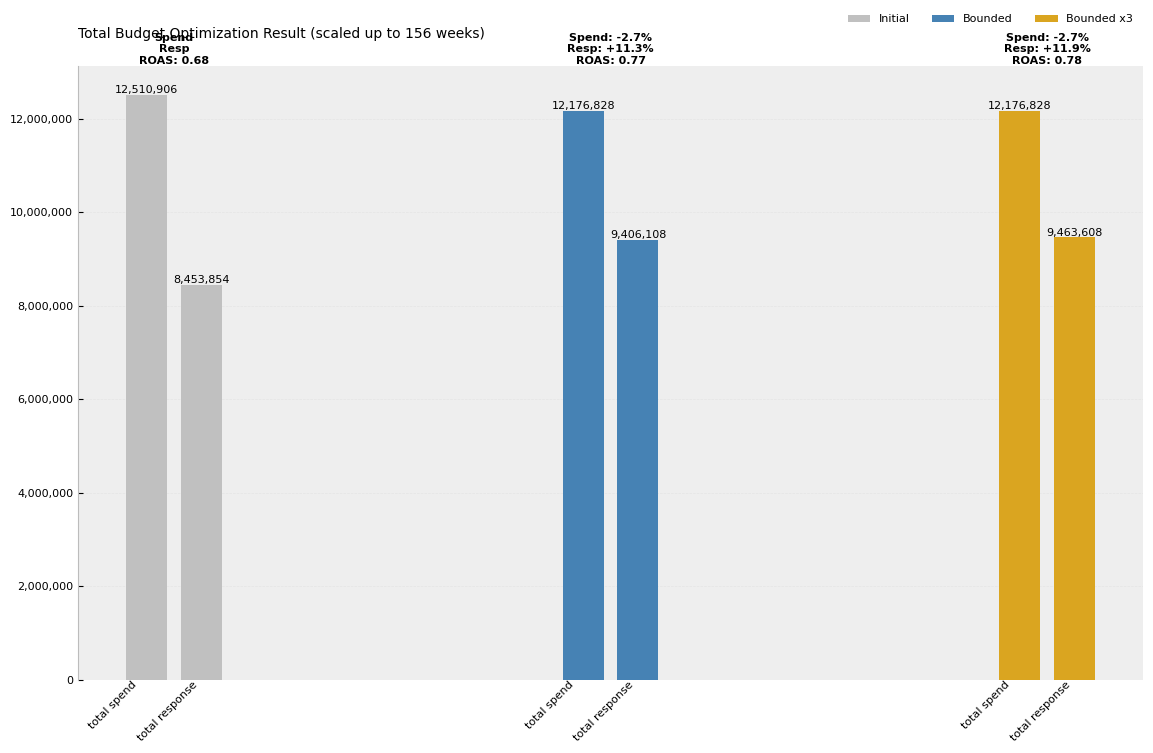

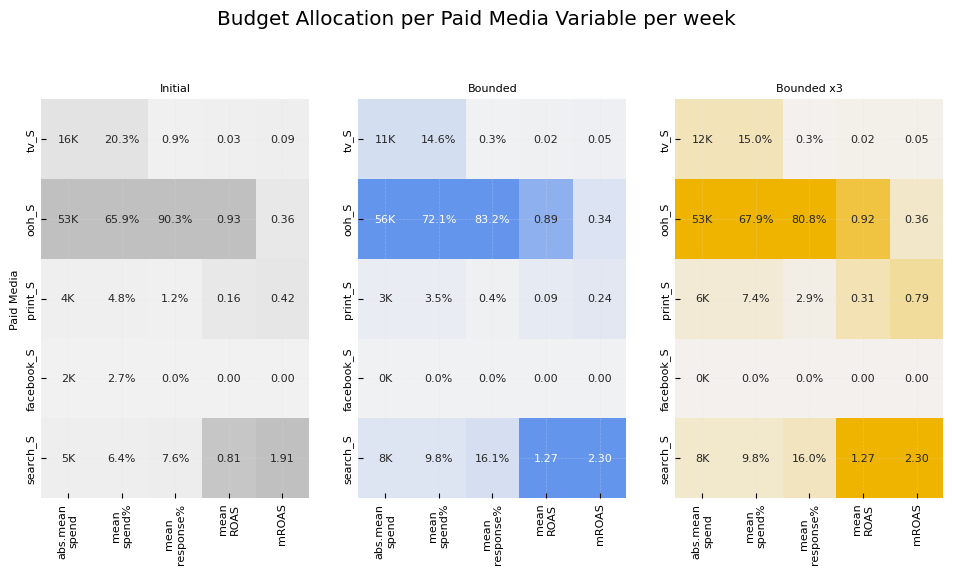

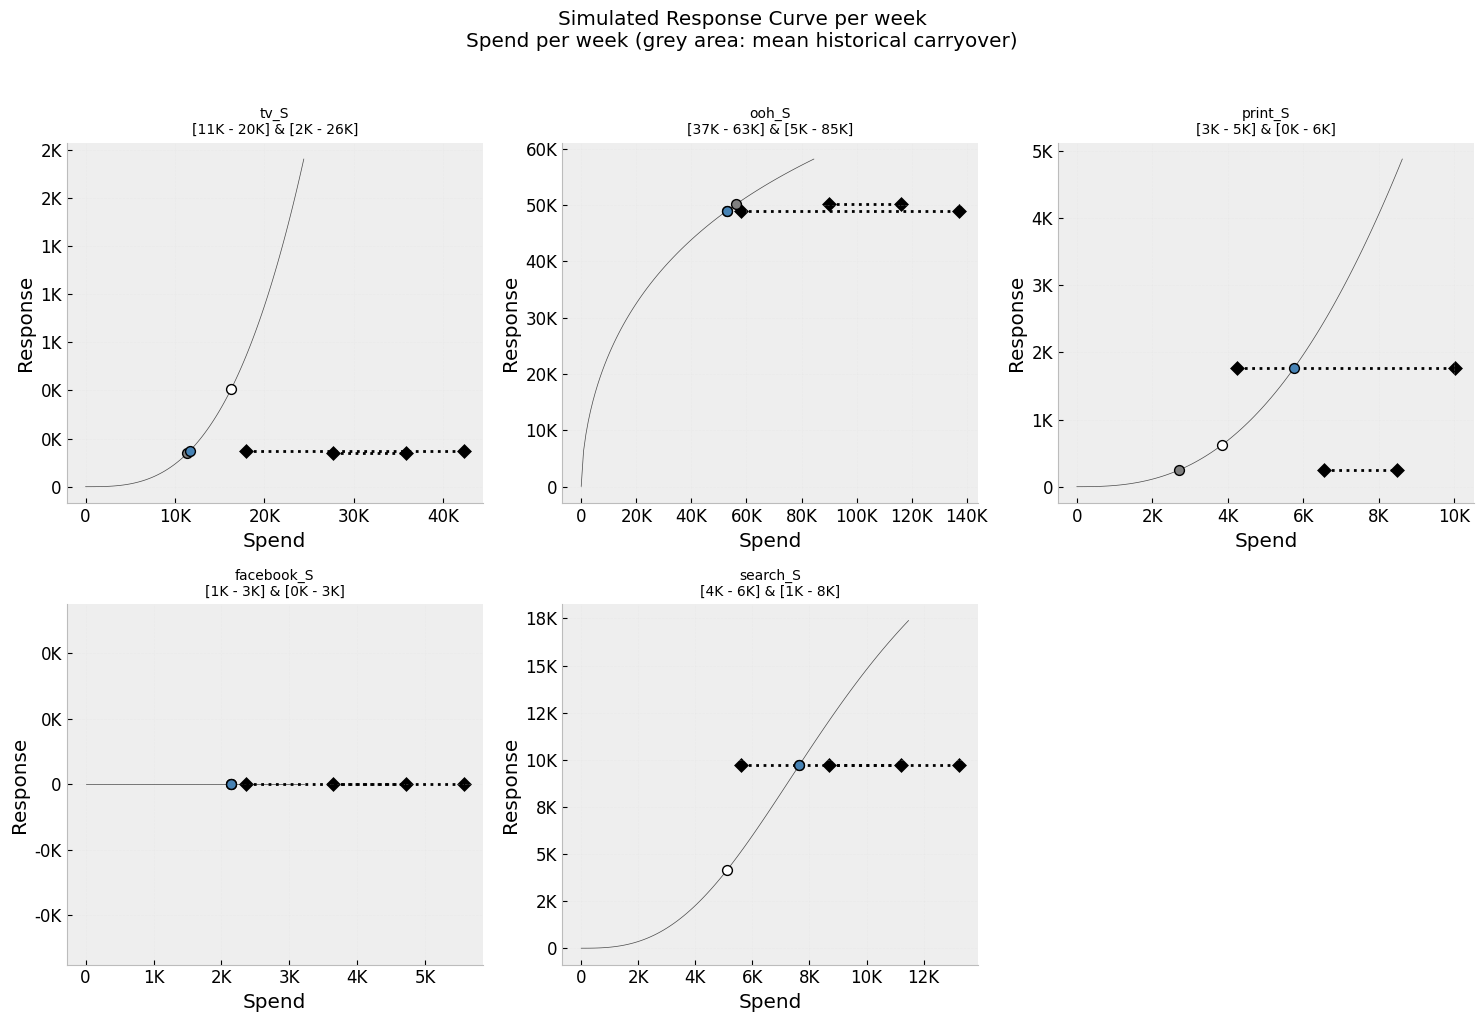

In [14]:
from robyn.visualization.allocator_visualizer import (
    AllocatorPlotter,
)
%load_ext autoreload
%autoreload 2
# Initialize plotter with just the essential data
plotter = AllocatorPlotter(
    allocation_result=max_response_result,
    budget_allocator=max_response_allocator
)

# Generate all plots
plots = plotter.plot_all(display_plots=False, export_location=None)

### Scenario 3: Target Efficiency
Optimize allocation based on target ROI/CPA.

In [15]:
# from robyn.allocator.constants import (
#     SCENARIO_TARGET_EFFICIENCY,  # Import this instead of SCENARIO_MAX_RESPONSE
#     ALGO_SLSQP_AUGLAG,
#     CONSTRAINT_MODE_EQ,
#     DEFAULT_CONSTRAINT_MULTIPLIER,
#     DATE_RANGE_ALL,
# )

# # Create allocator parameters matching R Example 3 for target efficiency
# allocator_params = AllocatorParams(
#     scenario=SCENARIO_TARGET_EFFICIENCY,  # Change scenario
#     total_budget=None,  # When None, it will use all available dates
#     # target_value is optional - when None:
#     # - For revenue (ROAS): defaults to 0.8x of initial ROAS
#     # - For conversion (CPA): defaults to 1.2x of initial CPA
#     target_value=None,
#     date_range="all",
#     # Use default constraints
#     channel_constr_low=[
#         0.1
#     ],  # Lower constraint for target_efficiency typically starts at 0.1
#     channel_constr_up=[
#         10
#     ],  # Upper constraint for target_efficiency typically goes up to 10
#     channel_constr_multiplier=3.0,
#     optim_algo="SLSQP_AUGLAG",
#     maxeval=100000,
#     constr_mode=CONSTRAINT_MODE_EQ,
#     plots=True,
# )

# # Initialize and run allocator same as before
# target_efficiency_allocator = BudgetAllocator(
#     mmm_data=mmm_data,
#     featurized_mmm_data=featurized_mmm_data,
#     hyperparameters=hyperparameters,
#     pareto_result=r_output_collect["pareto_result"],
#     select_model=select_model,
#     params=allocator_params,  # or allocator_params_custom
# )

# # Run optimization
# target_efficiency_result = target_efficiency_allocator.optimize()

In [16]:
# ## Step 4: Analyze Results
# print("\nOptimization Results Summary:")
# print("-" * 50)
# print(f"Model ID: {select_model}")
# print(f"Scenario: {target_efficiency_result.scenario}")
# print(f"Use case: {target_efficiency_result.usecase}")

# results_df = pd.DataFrame(
#     {
#         "Channel": target_efficiency_result.dt_optimOut.channels,
#         "Initial Spend": target_efficiency_result.dt_optimOut.init_spend_unit,
#         "Optimized Spend": target_efficiency_result.dt_optimOut.optm_spend_unit,
#         "Spend Change %": (
#             target_efficiency_result.dt_optimOut.optm_spend_unit
#             / target_efficiency_result.dt_optimOut.init_spend_unit
#             - 1
#         )
#         * 100,
#         "Initial Response": target_efficiency_result.dt_optimOut.init_response_unit,
#         "Optimized Response": target_efficiency_result.dt_optimOut.optm_response_unit,
#         "Response Lift %": (
#             target_efficiency_result.dt_optimOut.optm_response_unit
#             / target_efficiency_result.dt_optimOut.init_response_unit
#             - 1
#         )
#         * 100,
#     }
# )

# print("\nDetailed Results:")
# print(results_df.round(2))

# # Print additional diagnostics
# print("\nOptimization Parameters:")
# if target_efficiency_allocator.constraints.budget_constraint is not None:
#     print(
#         f"Total budget: {target_efficiency_allocator.constraints.budget_constraint:,.2f}"
#     )
# else:
#     print("Total budget: Unconstrained (Target Efficiency Mode)")
# print("Bound multiplier:", target_efficiency_allocator.params.channel_constr_multiplier)

# print("\nConstraint Violations:")
# violations = np.sum(
#     np.abs(
#         target_efficiency_result.dt_optimOut.optm_spend_unit
#         - target_efficiency_allocator.allocator_data_preparer.init_spend_unit
#     )
# )
# print(f"Total allocation adjustment: {violations:,.2f}")

In [17]:
# print(target_efficiency_result.dt_optimOut)
# print(target_efficiency_result.mainPoints)

In [18]:
# from robyn.visualization.allocator_visualizer import (
#     AllocatorPlotter,
# )
# %load_ext autoreload
# %autoreload 2
# # Initialize plotter with just the essential data
# plotter = AllocatorPlotter(
#     allocation_result=target_efficiency_result,
#     budget_allocator=target_efficiency_allocator
# )

# # Generate all plots
# plots = plotter.plot_all(display_plots=False, export_location=None)